In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [116]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    joint = (max(v)+1)*x+v
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int8')
    # shifted data
    # shift>0 => y shifted to positive side
    MIx=np.zeros(len(bitshift))
    MIv=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIjoint =np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        jj=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            jj = joint[shift:]
            rr=r[:-shift]
        elif shift==0:
            xx=x
            vv=v
            jj = joint
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            jj = joint[:shift]
            rr=r[-shift:]
#         Nxr, xedges, yedges = np.histogram2d(xx, rr, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
#         Nvr, xedges, yedges = np.histogram2d(vv, rr, bins=(np.append(np.unique(vv),(max(vv)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
#         Njr, xedges, yedges = np.histogram2d(jj, rr, bins=(np.append(np.unique(jj),(max(jj)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
#         px=np.sum(Nxr,axis=1)/np.sum(Nxr)
#         pv=np.sum(Nvr,axis=1)/np.sum(Nvr)
#         pj=np.sum(Njr,axis=1)/np.sum(Njr)
#         pr=np.sum(Nxr,axis=0)/np.sum(Nxr)
#         pxr=Nxr/np.sum(Nxr)
#         pvr=Nvr/np.sum(Nvr)
#         pjr=Njr/np.sum(Njr)
        
        pxr, xedges, yedges = np.histogram2d(xx, rr, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
        pvr, xedges, yedges = np.histogram2d(vv, rr, bins=(np.append(np.unique(vv),(max(vv)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
        pjr, xedges, yedges = np.histogram2d(jj, rr, bins=(np.append(np.unique(jj),(max(jj)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
        px=np.sum(pxr,axis=1)
        pv=np.sum(pvr,axis=1)
        pj=np.sum(pjr,axis=1)
        pj, xedges, yedges = np.histogram2d(xx, vv, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(vv),(max(vv)+1))), density = True)
        pj = pj.reshape(1,-1)
        pj = pj[np.where(pj)]
        pr=np.sum(pxr,axis=0)
        
        MIx[i]=np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr))/dt
        MIv[i]=np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr))/dt
        MIjoint[i]=np.nansum(pjr*np.log2(pjr/pj.reshape(-1,1)/pr))/dt
        
        PI_rX = np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr), axis = 0)
        PI_rV = np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr), axis = 0)
        Redun[i] = sum(np.minimum(PI_rX, PI_rV))/dt
    return timeshift, MIx, MIv, MIjoint, Redun

In [117]:
def  Shannon_entropy(serie):
    N , bin_edges = np.histogram(serie, bins=(np.append(np.unique(serie),(max(serie)+1))))
    p = N/np.sum(N)
    H = np.nansum(-1*p*np.log2(p))
    return H

In [118]:
#main
# OU ; input
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
tau=1
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(0.5-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 0.5
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, L)
#v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
v = np.diff(x)/dt
x=x[1:]
v=v[0:] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:]

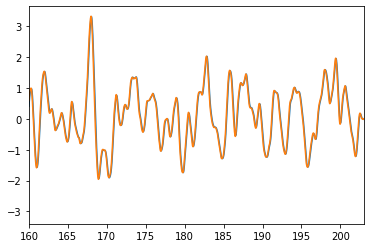

In [119]:
##response
# Model one: simple estimation
deltaT = 0.5
r1 = x+v*deltaT

# Model Two: negative group delay
#following paremeters match x+v*0.5s
alpha = 60.
beta =  2
K = 30.
g = 30.
#following paremeters match x+v*2s
# alpha = 19.9
# beta =  0.62
# K = 10
# g = 30
y=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz

y= y/np.std(y)
r1= r1/np.std(r1)
plt.plot(T,y)
plt.plot(T,r1)
plt.xlim(160,203)
    
#Chose which one to be response
r = r1

In [120]:
#assign states
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
rstate=np.zeros(len(r))
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)
xstate = EqualState(x, 6)
vstate = EqualState(v, 6)

In [121]:
#calculate information
window = [0,0] # second
timeshift, MI1, MI2, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
I3 = -(MIjoint-MI1-MI2)
print(I3)
print(MIjoint)
print(Redun)

[-13.65957956]
[49.57271087]
[15.97157273]


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib

In [122]:
#calculate information
window = [0,0] # second
timeshift, MI1, MI2, MIjoint, Redun = PIfunc(xstate, rstate, vstate, dt, window)
I3 = -(MIjoint-MI1-MI2)
print(I3)
print(MIjoint)
print(Redun)

[-5.58774715]
[26.12816118]
[0.59885546]


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply


In [123]:
#calculate information
window = [0,0] # second
timeshift, MI1, MI2, MIjoint, Redun = PIfunc(vstate, rstate, xstate, dt, window)
I3 = -(MIjoint-MI1-MI2)
print(I3)
print(MIjoint)
print(Redun)

[-4.49234965]
[21.06277785]
[0.59885546]


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply


In [53]:
range(0)

range(0, 0)

In [98]:
xx = xstate
vv = vstate
rr = rstate
xv = (max(vv)+1)*xx+vv
xr = (max(rr)+1)*xx+rr
vr = (max(vv)+1)*rr+vv
pxr, xedges, yedges = np.histogram2d(xx, rr, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
pvr, xedges, yedges = np.histogram2d(vv, rr, bins=(np.append(np.unique(vv),(max(vv)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
pxv, xedges, yedges = np.histogram2d(xx, vv, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(vv),(max(vv)+1))), density = True)

prxv, xedges, yedges = np.histogram2d(xv, rr, bins=(np.append(np.unique(xv),(max(xv)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
pxvr, xedges, yedges = np.histogram2d(vr, xx, bins=(np.append(np.unique(vr),(max(vr)+1)),np.append(np.unique(xx),(max(xx)+1))), density = True)
pvxr, xedges, yedges = np.histogram2d(xr, vv, bins=(np.append(np.unique(xr),(max(xr)+1)),np.append(np.unique(vv),(max(vv)+1))), density = True)

In [99]:
px=np.sum(pxr,axis=1)
pv=np.sum(pvr,axis=1)
pr=np.sum(pxr,axis=0)

P_xv=np.sum(prxv,axis=1)
P_vr=np.sum(pxvr,axis=1)
P_xr=np.sum(pvxr,axis=1)

In [100]:
MIxr=np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr))/dt
MIvr=np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr))/dt
MIxv=np.nansum(pxv*np.log2(pxv/px.reshape(-1,1)/pv))/dt

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [101]:
MIrxv=np.nansum(prxv*np.log2(prxv/P_xv.reshape(-1,1)/pr))/dt
MIxvr=np.nansum(pxvr*np.log2(pxvr/P_vr.reshape(-1,1)/px))/dt
MIvxr=np.nansum(pvxr*np.log2(pvxr/P_xr.reshape(-1,1)/pv))/dt

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
PI_rX = np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr), axis = 0)
PI_rV = np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr), axis = 0)
Redun_rXV = sum(np.minimum(PI_rX, PI_rV))/dt

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [103]:
PI_xR = np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr), axis = 1)
PI_xV = np.nansum(pxv*np.log2(pxv/px.reshape(-1,1)/pv), axis = 1)
Redun_xVR = sum(np.minimum(PI_xR, PI_xV))/dt

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [104]:
PI_vR = np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr), axis = 1)
PI_vX = np.nansum(pxv*np.log2(pxv/px.reshape(-1,1)/pv), axis = 0)
Redun_vXR = sum(np.minimum(PI_vR, PI_vX))/dt

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [105]:
Hx = Shannon_entropy(xx)/dt
Hv = Shannon_entropy(vv)/dt
Hr = Shannon_entropy(rr)/dt
Hxv = Shannon_entropy(xv)/dt
Hxr = Shannon_entropy(xr)/dt
Hvr = Shannon_entropy(vr)/dt
xvr = (max(xv)+1)*rr+xv
Hxvr = Shannon_entropy(xvr)/dt
Ixvr = Hx+Hv+Hr-(Hxv+Hvr+Hxr)+Hxvr
Ixvr

-13.192421532034473

In [106]:
print(MIxv, Hx+Hv-Hxv)
print(MIvr, Hr+Hv-Hvr)
print(MIxr, Hx+Hr-Hxr)

0.8187815202464768 0.8187815202466027
16.584017057547715 16.584017057547726
21.269854539602132 21.269854539602136


In [107]:
print(MIrxv, Hr+Hxv-Hxvr)
print(MIxvr, Hx+Hvr-Hxvr)
print(MIvxr, Hv+Hxr-Hxvr)

51.046293129184235 51.046293129184164
29.68108449267956 35.281057591883155
29.473976054628114 30.595220109828688


In [37]:
print(Redun_rXV)
print(Redun_xVR)
print(Redun_vXR)

16.679530587451996
0.715298987125253
0.6995636247901538


In [63]:
P_xr

array([1.66144410e-01, 1.66677779e-04, 1.64577639e-01, 2.00013334e-03,
       3.33355557e-05, 1.60477365e-01, 5.93372892e-03, 1.16674445e-04,
       1.44676312e-01, 2.13347557e-02, 3.16687779e-04, 1.31208747e-01,
       3.22021468e-02, 1.61677445e-03, 7.22048137e-02, 7.67051137e-02,
       1.75345023e-02, 3.33355557e-04])

In [64]:
pxr

array([[1.66144410e-01, 5.00033336e-04, 0.00000000e+00, 0.00000000e+00],
       [1.64577639e-01, 2.00013334e-03, 6.66711114e-05, 0.00000000e+00],
       [1.60477365e-01, 5.93372892e-03, 2.33348890e-04, 0.00000000e+00],
       [1.44676312e-01, 2.13347557e-02, 6.33375558e-04, 0.00000000e+00],
       [1.31208747e-01, 3.22021468e-02, 3.23354890e-03, 0.00000000e+00],
       [7.22048137e-02, 7.67051137e-02, 1.75345023e-02, 3.33355557e-04]])

In [74]:
serie = xr
N , bin_edges = np.histogram(serie, bins=(np.append(np.unique(serie),(max(serie)+1))))
p = N/np.sum(N)
p

array([1.66144410e-01, 5.00033336e-04, 1.64577639e-01, 2.00013334e-03,
       6.66711114e-05, 1.60477365e-01, 5.93372892e-03, 2.33348890e-04,
       1.44676312e-01, 2.13347557e-02, 6.33375558e-04, 1.31208747e-01,
       3.22021468e-02, 3.23354890e-03, 7.22048137e-02, 7.67051137e-02,
       1.75345023e-02, 3.33355557e-04])

In [75]:
print(-np.nansum(pxr*np.log2(pxr)), Hxr)

3.1168526700080923 311.6852670008093


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [73]:
P_xr-p

array([ 2.77555756e-17, -3.33355557e-04,  0.00000000e+00,  0.00000000e+00,
       -3.33355557e-05,  0.00000000e+00,  0.00000000e+00, -1.16674445e-04,
        0.00000000e+00,  0.00000000e+00, -3.16687779e-04,  0.00000000e+00,
        0.00000000e+00, -1.61677445e-03,  1.38777878e-17,  1.38777878e-17,
        0.00000000e+00,  0.00000000e+00])

In [127]:
0*np.log2(0)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

In [87]:
pj, xedges, yedges = np.histogram2d(xx, vv, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(vv),(max(vv)+1))), density = True)

In [89]:
np.shape(pj.reshape(-1,1))

(36, 1)

In [90]:
pj

array([[0.02570171, 0.03126875, 0.02526835, 0.03010201, 0.03050203,
        0.02380159],
       [0.02670178, 0.02650177, 0.03120208, 0.02886859, 0.02616841,
        0.02720181],
       [0.02753517, 0.02666844, 0.02983532, 0.02856857, 0.02660177,
        0.02743516],
       [0.03160211, 0.02876858, 0.02500167, 0.02013468, 0.02813521,
        0.0330022 ],
       [0.02673512, 0.0264351 , 0.02863524, 0.03380225, 0.02330155,
        0.02773518],
       [0.02836856, 0.0270018 , 0.02670178, 0.02516834, 0.03193546,
        0.02760184]])

In [91]:
np.unique(xv)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [94]:
a = np.array([0, 1, 0, 1,1,1,1,11,1,1,0])
a = a[np.where(a)]